In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import statistics as sts
import lmfit
from lmfit import Model
from scipy.stats import sem

from matplotlib import markers
import seaborn as sns

# Linear Fit
def line(x, m, b):
    return x * m + b
gmodel = Model(line)
param1 = gmodel.make_params(m = 1, b = 1)

colors = {'Pt' : 'tab:blue',
          'Al' : 'tab:orange', 
          'Mo' : 'tab:green',
          'Cr' : 'tab:red'}


sns.set_theme(style="whitegrid")

In [2]:

# Questions
plot = input('Plot?') # 'y' if you want to make the plots
save = input('Save?') # 'y' if you want to save the plots
f = input('Include linear fit?') # 'y' extra graph with fit and values

# Variables
split = 'LSB_07'
metals = {'0G_13': 'Pt',
          '0G_14' : 'Al',
          '0G_15' : 'Mo',
          '0G_16' : 'Cr',
        }
measurements = {'Pt' : {},
                'Al' : {},
                'Mo' : {},
                'Cr' : {}
                }

# Folder where the files are
data_path = os.path.join(Path.cwd().parent, 'Experiments', 'Data', 'Contact Resistance', split, 'LCR')
dict = {}

for i in os.listdir(data_path):
    files = os.listdir(os.path.join(data_path, i)) 
    for j in files:
        data = pd.read_csv(os.path.join(data_path, i, j))
        data.sort_values(by=['DC'], inplace = True)
        dict[j] = (data['DC'], data['Idc'], data['Vds'])####
        x, y = data['Vds'], data['Idc']
        result = gmodel.fit(y, param1, x = x)
        #result = gmodel.fit(dict[j][1], param1, x = dict[j][2])
        resistance = 1 / result.values['m']
        r_square = 1 - result.residual.var() / np.var(dict[j][1])
        measurements[metals[i]][j[:-4]] = (dict[j], resistance, r_square)
        
        if plot == 'y':

            fig, ax = plt.subplots(facecolor = 'white', dpi = 100)
            ax.set_title(metals[i] + ' ' + i + ' ' + j[:-4])
            ax.set_xlabel('Potential Vds (V)')
            ax.set_ylabel('Current Ids (A)')
            ax.scatter(dict[j][2], dict[j][1], s = 1, label = 'Measurement')
            ax.legend(markerscale = 5)

            if save == 'y':
                plt.savefig(os.path.join(Path.cwd().parent, 'Experiments', 'Data', 'Contact Resistance', split,
                            'Plots', i, metals[i] + ' ' + j[:-4]) + '.png', facecolor = 'white',  bbox_inches='tight')

            if f == 'y':
                
                fig, ax = plt.subplots(facecolor = 'white', dpi = 100)
                ax.set_title(metals[i] + ' ' + i + ' ' + j[:-4])
                ax.set_xlabel('Potential Vds (V)')
                ax.set_ylabel('Current Ids (A)')
                ax.scatter(dict[j][2], dict[j][1], s = 1, label = 'Measurement')
                ax.plot(dict[j][2], result.best_fit, alpha = 0.5, label = 'Linear Fit')
                ax.plot([],[], ' ', label = '{:.2f}'.format(resistance) + ' $\Omega$')
                ax.plot([],[], ' ', label = 'r$^2$ = ' + '{:.5f}'.format(r_square))
                ax.legend(markerscale = 5)

                if save == 'y':
                    plt.savefig(os.path.join(Path.cwd().parent, 'Experiments', 'Data', 'Contact Resistance', split,
                            'Plots', i, 'Fit_' + metals[i] + ' ' + j[:-4]) + '.png', facecolor = 'white',  bbox_inches='tight')

q = {} #filter P01, P02, P03 and P04

for i in measurements.keys():
    q[i] = []
    for j in measurements[i].keys():
        r_ohm = measurements[i][j][1]
        if 'P01' in j[3:]:
            q[i].append((2e-4, r_ohm))
        elif 'P02' in j[3:]:
            q[i].append((5e-4, r_ohm))
        elif 'P03' in j[3:]:
            q[i].append((10e-4, r_ohm))
        elif 'P04' in j[3:]:
            q[i].append((20e-4, r_ohm))


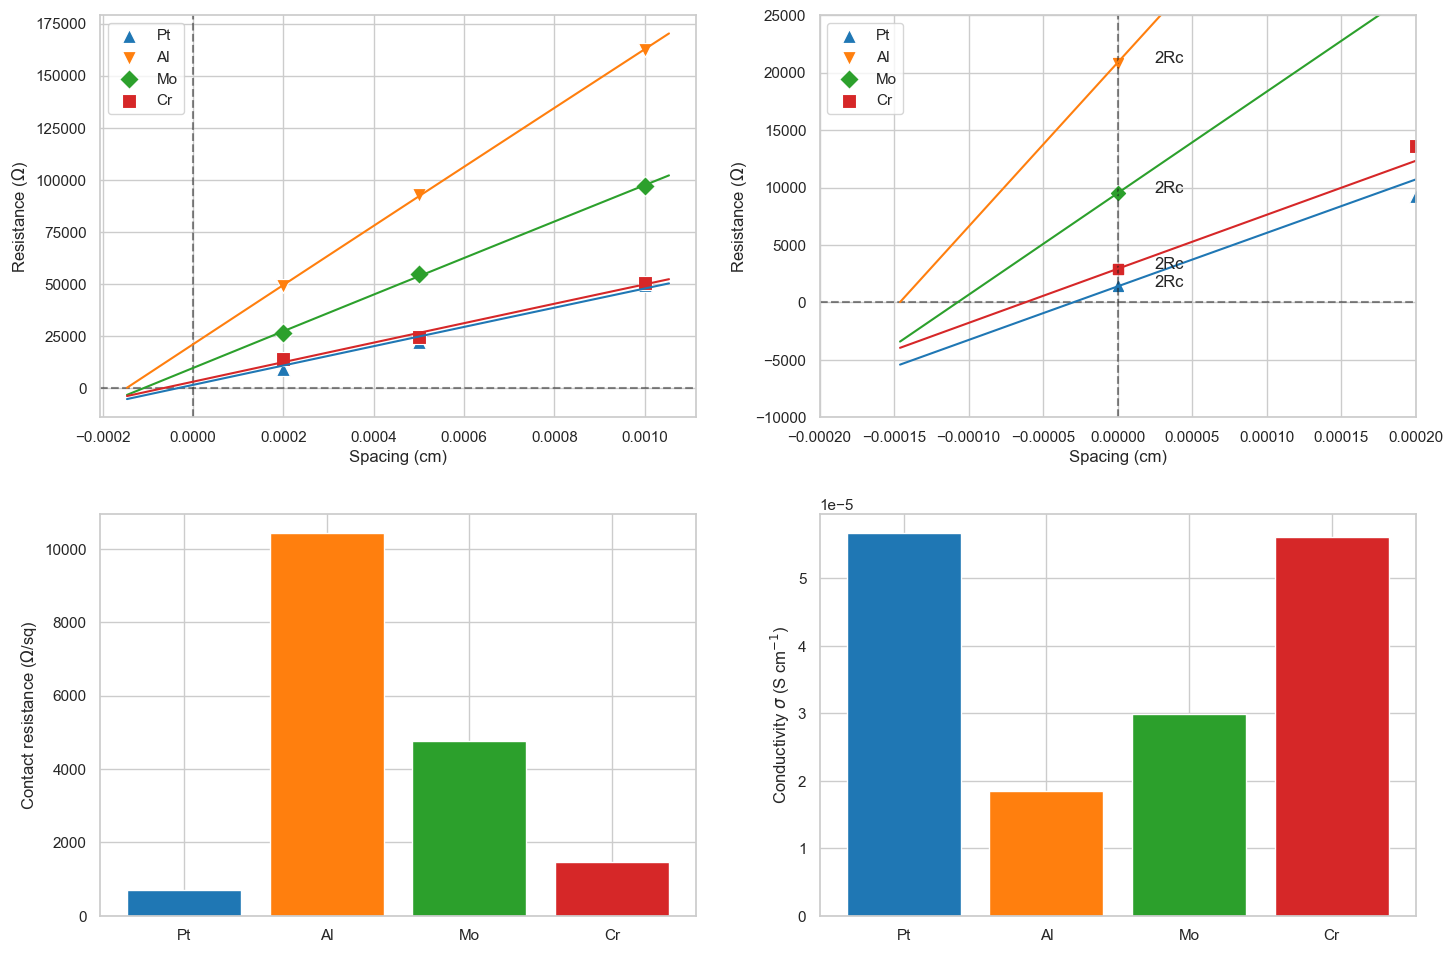

In [41]:

# Last model to get Contact resistance and Transfer Length 

# Function
def r_t(s, r_s, l_t, N, W, L):
    return (r_s * s / (N * W + (N-1) * (2 *s + L))) + (2 * r_s * l_t / (N * W + (N-1) * (2 *s + L)))

# Variables
metals = ['Pt', 'Al', 'Mo', 'Cr']
markers = ['^', 'v', 'D', 's']
w = 60 * 5e-4 + 59 * 3200e-4
b = 0 #Count for x-axis in bar plots
h = 5 #Count for x-axis in bar plots
x_0 = np.arange(-1.46, 11, 1) * 1e-4 # To evaluate the fit in desired range


#Create model and parameters
gmodel5 = Model(r_t)
param5 = gmodel5.make_params()
param5['r_s'].set(value = 1e8, min = 0)
param5['l_t'].set(value = 1, min = 1.5e-5)
param5['L'].set(value = 3200e-4, vary = False)
param5['W'].set(value = 5e-4, vary = False)
param5['N'].set(value = 60, vary = False)

#Plots
fig, ax = plt.subplots(2, 2, figsize = (15, 10), dpi = 100)
left, bottom, width, height = [0.11, 0.75, 0.135, 0.15]
#ax3 = fig.add_axes([left, bottom, width, height])

#Draw dashed line at zero axis
ax[0][1].axvline(0, color = 'k', alpha = 0.5, ls = '--')
ax[0][1].axhline(0, color = 'k', alpha = 0.5, ls = '--')
ax[0][0].axvline(0, color = 'k', alpha = 0.5, ls = '--')
ax[0][0].axhline(0, color = 'k', alpha = 0.5, ls = '--')
# ax3.axvline(0, color = 'k', alpha = 0.5, ls = '--')
# ax3.axhline(0, color = 'k', alpha = 0.5, ls = '--')

#Settings
ax[0][1].set_xlim(-0.0002, 0.0002)
ax[0][1].set_ylim(-10000, 25000)
ax[1][0].set_xticks([0, 1, 2, 3], metals)
ax[1][1].set_xticks([0, 1, 2, 3], metals)

for i in metals:
    x, y = np.sort(np.array(list(zip(*q[i]))))
    l = np.array([x, y])
    col = ['Spacing (cm)', 'Resistance ($\Omega$)']
    df = pd.DataFrame(data = l.T, columns = col)

    #Fit
    r = gmodel5.fit(y, param5, s = x) #result
    line = gmodel5.eval(r.params, s = x_0) #Evaluate fit in model function in custom range
    rc = gmodel5.eval(r.params, s = 0) # 2 times contact resistance
    l_t = r.best_values['l_t'] # transfer length
    r_s = r.best_values['r_s'] # sheet resistance
    rho_c = rc / 2 * l_t * w # Specific contact resistance
    sigma = 1 / (r_s * 0.2e-4)
    err_rs = r.params['r_s'].stderr # numerical standard error of sheet resistance

    #Lines 
    sns.lineplot(x = x_0, y = line, ax = ax[0][0], color = colors[i])
    sns.lineplot(x = x_0, y = line, ax = ax[0][1], color = colors[i])
    # sns.lineplot(x = x_0, y = line, ax = ax3)
    
    #Scatter
    sns.scatterplot(data = df, x = col[0], y = col[1], ax = ax[0][0], s = 100, marker = markers[b], color = colors[i], label = i)
    sns.scatterplot(data = df, x = col[0], y = col[1], ax = ax[0][1], s = 100, marker = markers[b], color = colors[i], label = i)
    ax[0][1].scatter(0, rc, color = colors[i], s = 50, marker = markers[b])
    # ax[0][1].scatter(-2 * l_t,0, color = colors[i], s = 50, marker = markers[b])
    sns.scatterplot(data = df, x = col[0], y = col[1], ax = ax3, s = 100, marker = markers[b])
    # ax3.scatter([-2 * l_t, 0],[0, rc])

    #Bars
    # ax[1][0].bar([b], height = [r_s], color = colors[i], yerr = err_rs)
    ax[1][0].bar([b], height = [rc / 2], color = colors[i])
    ax[1][1].bar([b], height = [sigma], color = colors[i])

    #Text
    ax[0][1].text(0.000025, rc, '2Rc') # = ' + '{:.2f}'.format(rc) + ' $\Omega$', ha = 'left')
    #ax[0][1].text(-2 * l_t, 5000, '2L$_t$ = ' + '{:.2e}'.format(-2 * l_t) + ' cm', rotation = 'vertical', ha = 'center')
    # ax3.text(-2 * l_t, 800, '2L$_T$', rotation = 'vertical', ha = 'center')
    # ax3.text(0.00005, rc, '2R$_C$', ha = 'center')

    # #Settings
    # ax3.set_xlim(-0.00025, 0.00005)
    # ax3.set_ylim(-5000, 25000)
    # ax3.set_xticks([0], [''])#[0, 0.0001, 0.0002],[0,1,2])
    # ax3.set_yticks([0], [''])
    # ax3.set_xlabel('')#'Spacing (um)')
    # ax3.set_ylabel('')
    ax[1][0].set_ylabel('Contact resistance ($\Omega$/sq)') #'Specific Contact Resistance $P_C$ ($\Omega$cm$^2$)')
    ax[1][1].set_ylabel('Conductivity $\sigma$ (S cm$^{-1}$)')

    b += 1
    h += 1


fig.tight_layout(pad=2.0) # Space between graphs in subplot


C1_P01.txt 48918.725711316605 1.0537217443348111e-07
C2_P03.txt 162392.90196162427 1.3006495171252618e-08



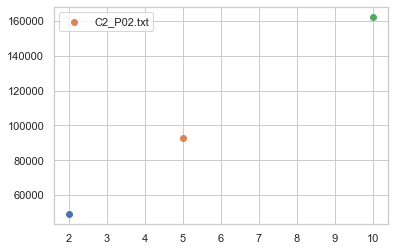

In [4]:
data_path = os.path.join(Path.cwd().parent, 'Experiments', 'Data', 'Contact Resistance', split, 'LCR', '0G_14')
dir = os.listdir(data_path)
dict = {}

for i in dir:
    path = os.path.join(data_path, i)
    data = pd.read_csv(path)
    data.sort_values(by=['DC'], inplace = True)
    x, y = data['Vds'], data['Idc']
    r = gmodel.fit(y, param1, x = x)
    m = r.best_values['m']
    resistance = 1 / m
    if '01' in i:
        plt.scatter(2, resistance)
        print(i, 1/r.params['m'], r.params['m'].stderr)
    elif '02' in i:
        plt.scatter(5, resistance, label = i)
    elif '03' in i:
        plt.scatter(10, resistance)
        print(i, 1/r.params['m'], r.params['m'].stderr)

    # elif '04' in i:
    #     plt.scatter(20, resistance, label = i)   
    
    # plt.plot(x, y)

    


plt.legend()

print('')

